In [219]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib
import metpy
from metpy.calc import specific_humidity_from_dewpoint
import metpy.units
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os

plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def shift_time_to_feb2(time_index):
    """Shift all timestamps later than February to align as if year starts Feb 2."""
    shifted = []
    time_late_year_start = time_index.where(time_index.dt.month>2, drop=True)[0].values
    for t in pd.to_datetime(time_index):
        if t.month > 2:
            # shift so year starts on Feb 2
            # subtract the number of days between Jan 1 and Feb 2
            days_to_shift = (time_late_year_start -
                             pd.Timestamp(year=t.year, month=2, day=2, hour=0)).days
            shifted.append(t - pd.Timedelta(days=days_to_shift))
        else:
            shifted.append(t)
    return pd.DatetimeIndex(shifted)

In [4]:
exp_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/era5/diurnal_play'
loc_names = ['russia', 'spain', 'australia', 'canada']
n_loc = len(loc_names)
ds = [xr.load_dataset(os.path.join(exp_dir, loc_names[i],'output.nc')).isel(longitude=0, latitude=0) for i in range(n_loc)]
# Normalize time dimension so we can merge locations
# Pick a dummy reference datetime
time_origin = ds[0].time.isel(time=0).values      # start with first day of the first dataset for all locations as dummy time
year = time_origin.astype('datetime64[Y]').astype(int)+1970
for i in range(n_loc):
    if ds[i].latitude < 0:
        # for SH, saved Jan, Nov, Dec for one year so big gap between jan and nov. Shift nov to start Feb 2nd so blank Feb 1st to distinguish
        ds[i] = ds[i].assign_coords(time=shift_time_to_feb2(ds[i].time))
    ds[i]['time_start'] = ds[i].time.isel(time=0)           # record date of start of the period recorded (JJA for NH or NDJ for SH)
    ds[i] = ds[i].assign_coords(time=time_origin + (ds[i].time - ds[i]['time_start']))
ds = xr.concat(ds, dim=xr.Variable("loc", loc_names))

# Compute 2m specific humitidity, add to ds.q.isel(plev=0)*0 to keep reasonable xarray info
ds['q2m'] = ds.q.isel(plev=0)*0 + specific_humidity_from_dewpoint(ds.sp * metpy.units.units.pascal, ds.d2m * metpy.units.units.kelvin).metpy.magnitude

## Diurnal Cycle
Look at the hottest day in a given location, see how the environmental temperature profile and various measures of the boundary layer height vary over the diurnal cycle.

In [130]:
# Compute different measures of boundary layer height
# Explicit boundary layer height - nan if below surface
ds['p_bl'] = xr.apply_ufunc(
    np.interp,
    ds.blh + ds.geopotential_surf/g,        # x-values (heights) to interpolate at
    ds.z.where(ds.plev<=ds.sp/100)/g,          # known z-values
    ds.plev.where(ds.plev<=ds.sp/100),       # known p-values
    input_core_dims=[[], ['plev'], ['plev']],  # specify 'plev' is core dimension
    vectorize=True
) * 100
ds['t_bl'] = dry_profile_temp(ds.t2m, ds.sp, ds.p_bl)

# lcl with surface values
ds['p_lcl'], ds['t_lcl'] = lcl_metpy(ds.t2m.fillna(0), ds.q2m.fillna(0), ds.sp.fillna(0))

# lcl with lowest pressure level above surface
low_lev_ind = ds.plev.where(ds.plev<=ds.sp.fillna(np.inf)/100).argmax(dim='plev')
ds['p_low_lev'] = ds.plev.isel(plev=low_lev_ind) * 100
ds['t_low_lev'] = ds.t.isel(plev=low_lev_ind)
ds['q_low_lev'] = ds.q.isel(plev=low_lev_ind)
ds['z_low_lev'] = ds.z.isel(plev=low_lev_ind)/g
ds['p_lcl2'], ds['t_lcl2'] = lcl_metpy(ds.t_low_lev.fillna(0), ds.q_low_lev.fillna(0), ds['p_low_lev'].fillna(0))
ds['mse_low_lev'] = moist_static_energy(ds.t_low_lev, ds.q_low_lev, ds.z_low_lev)

# At boundary layer following lowest pressure level above surface
ds['t_bl2'] = dry_profile_temp(ds['t_low_lev'], ds['p_low_lev'], ds.p_bl)

In [131]:
def apply_func_vec(func, n_lev_args, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    # n_lev_args is the number of arguments (ignoring pressure) with a plev dimension. The non plev args must be given first
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * (len(args)-n_lev_args) + [['plev']] * (n_lev_args + 1),
                          output_core_dims=[['plev']], vectorize=True, dask='parallelized', output_dtypes=[float])


def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def mse_env_profile(p_lcl, q_refht, temp_env, z_env, p):
    # MSE profile maintains surface specific humifity up to LCL then is saturated
    mse_profile = moist_static_energy(temp_env, sphum_sat(temp_env, p), z_env)
    # Replace values below the LCL with MSE using q_refht
    mask = p >= p_lcl
    mse_profile = xr.where(mask, moist_static_energy(temp_env, q_refht, z_env), mse_profile)
    return mse_profile

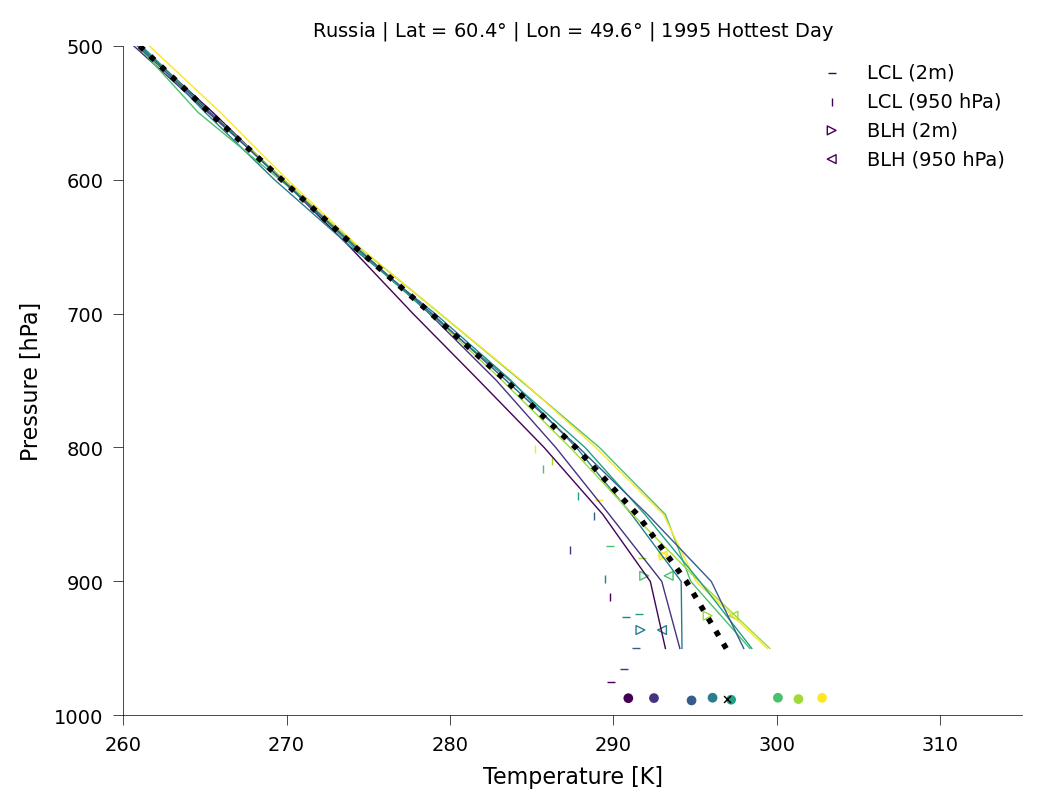

In [132]:
temp2m_daily_max = ds.t2m.resample(time="1D").max()
hottest_day = temp2m_daily_max.time.isel(time=temp2m_daily_max.argmax(dim='time'))
hottest_day = {loc_names[i]: pd.to_datetime(hottest_day.values)[i].date() for i in range(n_loc)}


loc_plot = 'russia'
ds_use = ds.sel(loc=loc_plot, time=ds.time.dt.date == hottest_day[loc_plot])
# ds_use['p_lcl'], ds_use['t_lcl'] = lcl_metpy(ds_use.t2m, ds_use.q2m, ds_use.sp)
# Color by rank in hours of day of t2m
# Normalize over the range of the dataset
norm = matplotlib.colors.Normalize(vmin=0, vmax=ds_use.time.size-1)
# Get indices that would sort the array
sorted_indices = np.argsort(ds_use.t2m.values)
# Create an array of ranks
ranks = np.empty_like(sorted_indices)
ranks[sorted_indices] = np.arange(ds_use.time.size)  # coldest=0, hottest=len-1
# Choose a colormap
cmap = matplotlib.cm.get_cmap('viridis')

temp_sqe = apply_func_vec(conv_neutral_profile, 0, ds_use.plev[::-1]*100, ds_use.t_lcl2, ds_use.p_lcl2)

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 5.8)
for i in range(ds_use.time.size):
    p_use = ds_use.plev < ds_use.sp.isel(time=i)/100
    ax.plot(ds_use.t.isel(time=i).where(p_use), ds_use.plev.where(p_use), color=cmap(norm(ranks[i])))
    ax.scatter(ds_use.t_lcl.isel(time=i), ds_use.p_lcl.isel(time=i)/100, color=cmap(norm(ranks[i])), marker='_', s=10,
               label='LCL (2m)' if i==0 else None)
    ax.scatter(ds_use.t_lcl2.isel(time=i), ds_use.p_lcl2.isel(time=i)/100, color=cmap(norm(ranks[i])), marker='|', s=10,
               label=f'LCL ({int(ds_use.plev.where(p_use).max())} hPa)' if i==0 else None)
    ax.scatter(ds_use.t_bl.isel(time=i), ds_use.p_bl.isel(time=i)/100, color=cmap(norm(ranks[i])), marker='>', s=10, facecolors='none', lw=0.5,
               label='BLH (2m)' if i==0 else None)
    ax.scatter(ds_use.t_bl2.isel(time=i), ds_use.p_bl.isel(time=i)/100, color=cmap(norm(ranks[i])), marker='<', s=10, facecolors='none', lw=0.5,
               label=f'BLH ({int(ds_use.plev.where(p_use).max())} hPa)' if i==0 else None)
    # if ranks[i] == np.max(ranks):
    #     ax.plot(temp_sqe.isel(time=i), ds_use.plev[::-1])
ax.scatter(ds_use.t2m, ds_use.sp/100, c=ranks, cmap=cmap)
ax.plot(ds_use.t.mean(dim='time').where(p_use), ds_use.plev.where(p_use), color='k', linestyle=':', lw=2)
ax.scatter(ds_use.t2m.mean(), ds_use.sp.mean()/100, c='k', marker='x')
ax.set_ylim(1000,500)
ax.set_xlim(260, 315)
ax.legend()
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')
ax.set_title(
    f'{loc_plot.capitalize()} | Lat = {ds_use.latitude:.1f}$\degree$ | Lon = {ds_use.longitude:.1f}$\degree$ |'
    f' {year} Hottest Day', y=0.99, fontsize=7)
plt.show()

### Check Diurnal cycle of other important variables
It appears that dew point temperature and 500hPa temperature both have a pretty minimal diurnal temperature cycle compared to $T_{2m}$, so can probably get away with using daily mean $T_{500}$ and $D_{2m}$ in calculations, along with daily max $T_{2m}$.

We can then compute the effective humidity required for no CAPE at 500hPa, but have no way of computing an error to determine whether this represents a reasonable approximation of the temperature profile.

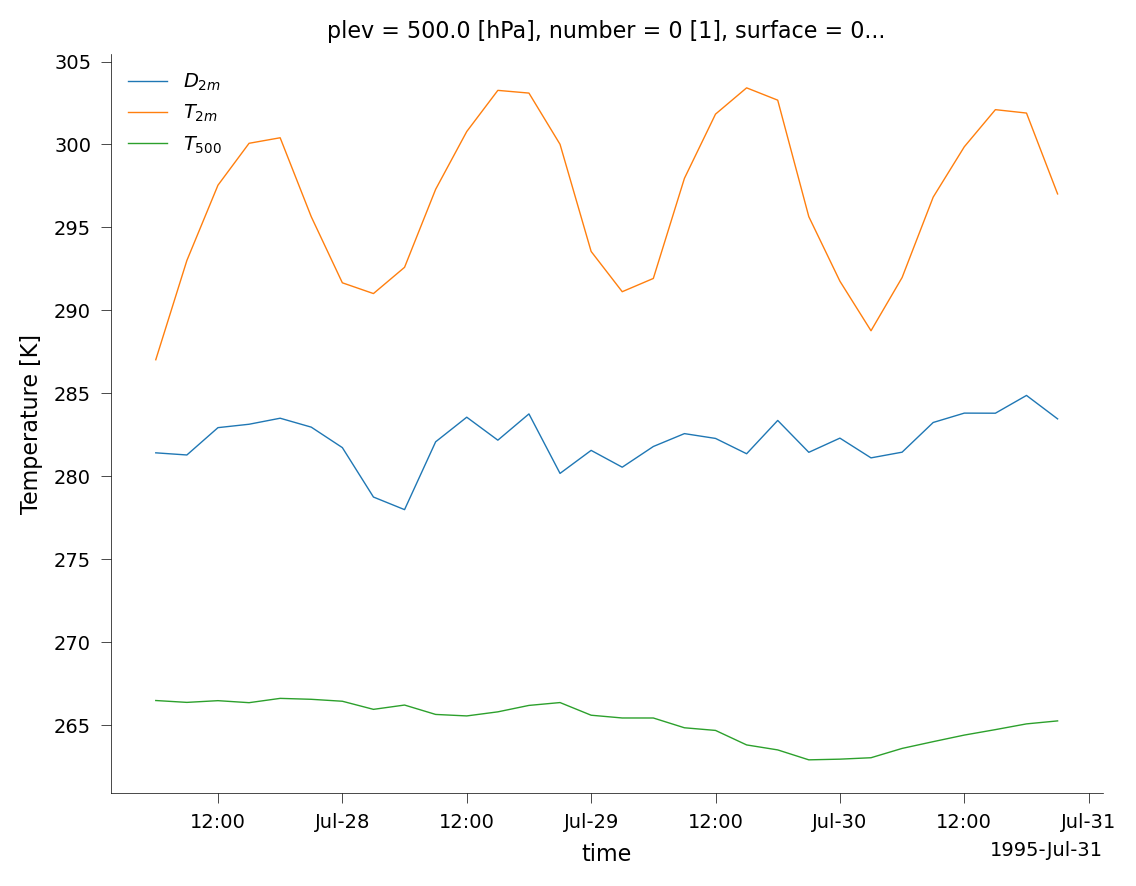

In [405]:
ds.d2m.isel(loc=1, time=slice(30*3*5, 30*3*5+30)).plot(label='$D_{2m}$')
ds.t2m.isel(loc=1, time=slice(30*3*5, 30*3*5+30)).plot(label='$T_{2m}$')
ds.t.isel(loc=1, time=slice(30*3*5, 30*3*5+30)).sel(plev=500).plot(label='$T_{500}$')
plt.gca().legend()

## Daily max dataset
From now on we only consider the variables on a given day conditioned on hour of maximum $T_{2m}$

In [133]:
daily_max_idx = ds.t2m.resample(time='1D').reduce(np.argmax, dim='time')
daily_max_time = ds.t2m.time.resample(time='1D').first() + np.timedelta64(0,'h')  # placeholder

In [135]:
# Get the actual times corresponding to daily max
daily_max_time = ds.t2m.time.resample(time='1D').first() + np.timedelta64(0,'h')  # placeholder
# Instead, for advanced indexing, use:
ds_daily_max = ds.groupby('time.date').map(lambda x: x.isel(time=x['t2m'].fillna(0).argmax(dim='time')))
ds_daily_max['mse_sat'] = moist_static_energy(ds_daily_max.t, sphum_sat(ds_daily_max.t, ds_daily_max.plev*100), ds_daily_max.z/g)

In [232]:
ds_daily_max['q_low_lev5'] = ds_daily_max['q_low_lev'] - (ds_daily_max.mse_low_lev - ds_daily_max.mse_sat.sel(plev=500)) * 1000 / L_v
ds_daily_max['p_lcl5'], ds_daily_max['t_lcl5'] = lcl_metpy(ds_daily_max.t_low_lev.fillna(0), ds_daily_max.q_low_lev5.fillna(0),
                                                           ds_daily_max.p_low_lev.fillna(0))
ds_daily_max['t_sqe5'] = apply_func_vec(conv_neutral_profile, 0, ds_daily_max.plev[::-1]*100, ds_daily_max.t_lcl5, ds_daily_max.p_lcl5)
ds_daily_max['t_sqe'] = apply_func_vec(conv_neutral_profile, 0, ds_daily_max.plev[::-1]*100, ds_daily_max.t_lcl2, ds_daily_max.p_lcl2)[::-1]

ds_daily_max['mse_env'] = apply_func_vec(mse_env_profile, 2, ds_daily_max.plev*100, ds_daily_max.p_lcl2, ds_daily_max.q_low_lev,
                                         ds_daily_max.t, ds_daily_max.z/g)
ds_daily_max['mse_env5'] = apply_func_vec(mse_env_profile, 2, ds_daily_max.plev*100, ds_daily_max.p_lcl5, ds_daily_max.q_low_lev5,
                                          ds_daily_max.t, ds_daily_max.z/g)
ds_daily_max['mse_low_lev5'] = moist_static_energy(ds_daily_max.t_low_lev, ds_daily_max.q_low_lev5, ds_daily_max.z_low_lev)

### BLH vs LCL
Below we see that the LCL seems to be higher than the LCL

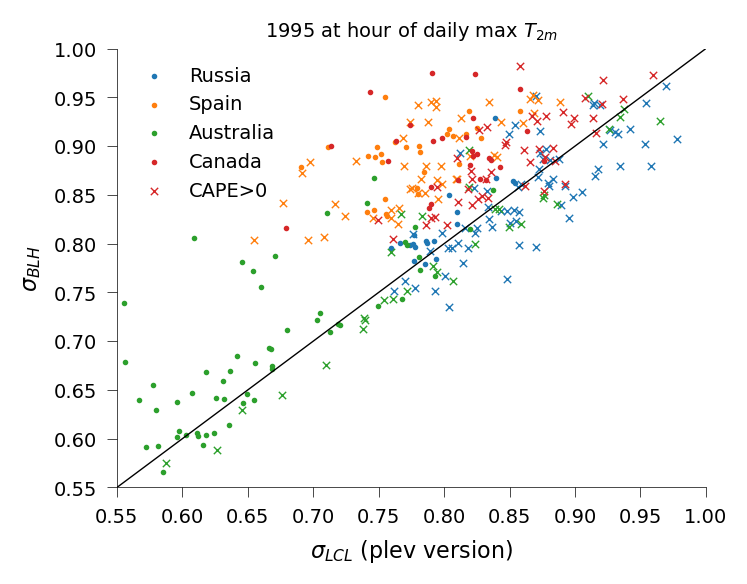

In [136]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 3.8)
for i in range(n_loc):
    ds_use = ds_daily_max.isel(loc=i)
    p_use = ds_use.cape==0
    plt.scatter((ds_use.p_lcl2/ds_use.sp).where(p_use), (ds_use.p_bl/ds_use.sp).where(p_use),
                label=loc_names[i].capitalize(), s=1, color=f"C{i}")
    p_use = ds_use.cape>0
    plt.scatter((ds_use.p_lcl2/ds_use.sp).where(p_use), (ds_use.p_bl/ds_use.sp).where(p_use), s=7,
                marker='x', color=f"C{i}", label='CAPE>0' if i==n_loc-1 else None)
ax.plot([0.55, 1], [0.55, 1], color='k')
ax.set_xlim(0.55, 1)
ax.set_ylim(0.55, 1)
ax.set_xlabel('$\sigma_{LCL}$ (plev version)')
ax.set_ylabel('$\sigma_{BLH}$')
ax.legend()
ax.set_title(f'{year}'+' at hour of daily max $T_{2m}$', y=0.99, fontsize=7)
plt.show()

### SQE profile on local maxima days
Below we see how the SQE profile compares to the environmental profile. We say that there is the expected correlation between larger CAPE and SQE profile being warmer than environmental in free troposphere.

We also compare to an effective SQE computed with effective humidity.

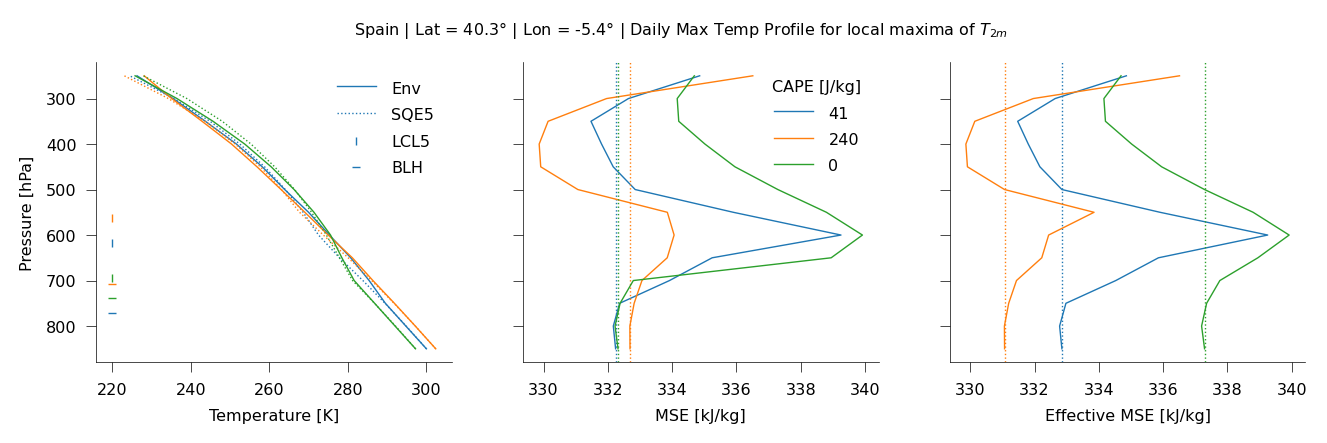

In [294]:
loc_plot = 'spain'
ds_use = ds_daily_max.sel(loc=loc_plot)
window = 3  # consider a point a local max if bigger than neighbors
rolled = ds_use.t2m.rolling(date=window, center=True).reduce(np.max)
temp_thresh = ds_use.t2m.quantile(0.92)
local_max_ind = np.where((ds_use.t2m == rolled) & (ds_use.t2m > temp_thresh))[0]
ds_use['t_sqe'] = apply_func_vec(conv_neutral_profile, 0, ds_use.plev[::-1]*100, ds_use.t_lcl2, ds_use.p_lcl2)[::-1]

# MSE profile
mse_env = apply_func_vec(mse_env_profile, 2, ds_use.plev*100, ds_use.p_lcl2, ds_use.q_low_lev, ds_use.t, ds_use.z/g)
mse_env5 = apply_func_vec(mse_env_profile, 2, ds_use.plev*100, ds_use.p_lcl5, ds_use.q_low_lev5, ds_use.t, ds_use.z/g)
mse_low_lev5 = moist_static_energy(ds_use.t_low_lev, ds_use.q_low_lev5, ds_use.z_low_lev)

sqe_show = ''
sqe_show = 5

fig, ax = plt.subplots(1, 3, sharey=True)
isca_tools.plot.fig_resize(fig, 7.8)
for i in range(len(local_max_ind)):
    p_use = ds_use.plev < ds_use.sp.isel(date=local_max_ind[i])/100
    ax[0].plot(ds_use.t.isel(date=local_max_ind[i]).where(p_use), ds_use.plev.where(p_use), color=f"C{i}", label='Env' if i==0 else None)
    ax[0].plot(ds_use[f't_sqe{sqe_show}'].isel(date=local_max_ind[i]).where(p_use), ds_use.plev.where(p_use), color=f"C{i}", linestyle=':',
               label=f"SQE{sqe_show}" if i==0 else None)
    ax[0].scatter(220, ds_use[f'p_lcl{2 if sqe_show == "" else sqe_show}'].isel(date=local_max_ind[i])/100,
                  marker='|', s=10, color=f"C{i}", label=f'LCL{sqe_show}' if i==0 else None)
    ax[0].scatter(220, ds_use.p_bl.isel(date=local_max_ind[i])/100,
                  marker='_', s=10, color=f"C{i}", label='BLH' if i==0 else None)
    ax[1].plot(mse_env.isel(date=local_max_ind[i]).where(p_use), ds_use.plev.where(p_use), color=f"C{i}",
               label=f"{ds_use.cape.isel(date=local_max_ind[i]):.0f}")
    ax[1].axvline(ds_use.mse_low_lev.isel(date=local_max_ind[i]), color=f"C{i}", linestyle=':')
    ax[2].plot(mse_env5.isel(date=local_max_ind[i]).where(p_use), ds_use.plev.where(p_use), color=f"C{i}",
               label=f"{ds_use.cape.isel(date=local_max_ind[i]):.0f}")
    ax[2].axvline(mse_low_lev5.isel(date=local_max_ind[i]), color=f"C{i}", linestyle=':')
ax[0].invert_yaxis()
ax[0].legend()
ax[1].legend(title='CAPE [J/kg]')
ax[2].sharex(ax[1])
fig.suptitle(
    f'{loc_plot.capitalize()} | Lat = {ds_use.latitude:.1f}$\degree$ | Lon = {ds_use.longitude:.1f}$\degree$ |'
    ' Daily Max Temp Profile for local maxima of $T_{2m}$', y=0.99, fontsize=7)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('MSE [kJ/kg]')
ax[2].set_xlabel('Effective MSE [kJ/kg]')
update_fontsize(fig)
plt.show()

### LCL5 from effective humidity
Below, we see that the LCL computed from the effective humidity is basically always closer to the surface (more moist) than the physical LCL for days with zero CAPE. Also, it reflects the boundary layer height more closely.

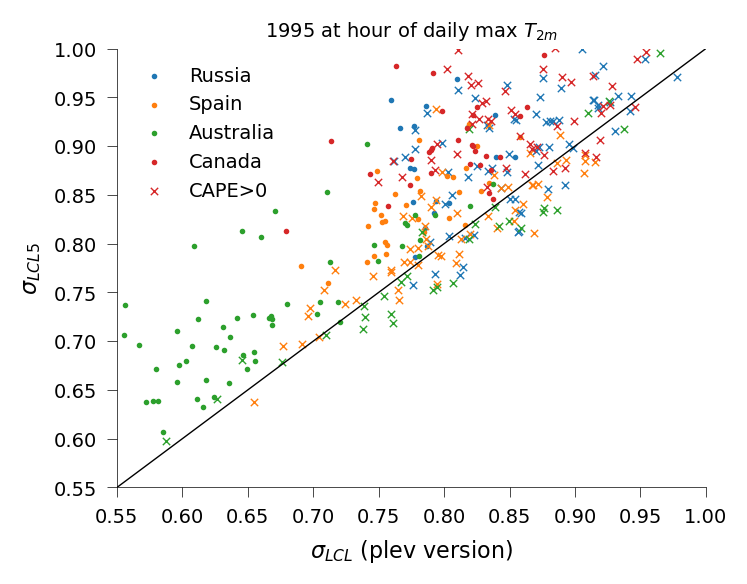

In [201]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 3.8)
for i in range(n_loc):
    ds_use = ds_daily_max.isel(loc=i)
    p_use = ds_use.cape==0
    plt.scatter((ds_use.p_lcl2/ds_use.sp).where(p_use), (ds_use.p_lcl5/ds_use.sp).where(p_use),
                label=loc_names[i].capitalize(), s=1, color=f"C{i}")
    p_use = ds_use.cape>0
    plt.scatter((ds_use.p_lcl2/ds_use.sp).where(p_use), (ds_use.p_lcl5/ds_use.sp).where(p_use), s=7,
                marker='x', color=f"C{i}", label='CAPE>0' if i==n_loc-1 else None)
ax.plot([0.55, 1], [0.55, 1], color='k')
ax.set_xlim(0.55, 1)
ax.set_ylim(0.55, 1)
ax.set_xlabel('$\sigma_{LCL}$ (plev version)')
ax.set_ylabel('$\sigma_{LCL5}$')
ax.legend()
ax.set_title(f'{year}'+' at hour of daily max $T_{2m}$', y=0.99, fontsize=7)
plt.show()

### Effective humidity as CAPE proxy
Below we see that days with significant CAPE have larger physical relative humidity than effective relative humidity; and the greater the difference the greater the CAPE.

This behaviour is expected as long as the 500hPa level contributed to the CAPE.

In [378]:
ds_daily_max['rh_low_lev'] = ds_daily_max.q_low_lev / sphum_sat(ds_daily_max.t_low_lev, ds_daily_max.p_low_lev)
ds_daily_max['rh_low_lev5'] = ds_daily_max.q_low_lev5 / sphum_sat(ds_daily_max.t_low_lev, ds_daily_max.p_low_lev)

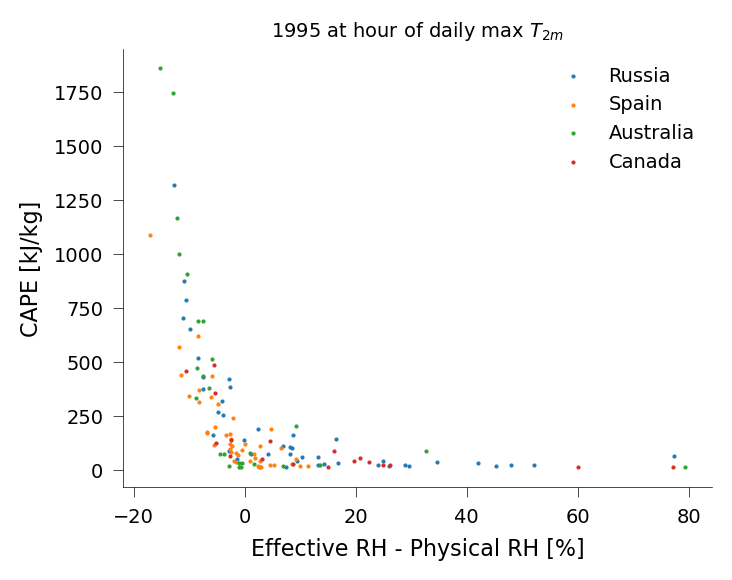

In [381]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 3.8)
for i in range(n_loc):
    ds_use = ds_daily_max.isel(loc=i)
    p_use = ds_use.cape>10
    plt.scatter((ds_use.rh_low_lev5 - ds_use.rh_low_lev).where(p_use) * 100, ds_use.cape.where(p_use),
                marker='.', label=loc_names[i].capitalize(), s=1, color=f"C{i}")
# ax.plot([0.55, 1], [0.55, 1], color='k')
# ax.set_xlim(0.55, 1)
# ax.set_ylim(0.55, 1)
ax.set_xlabel('Effective RH - Physical RH [%]')
ax.set_ylabel('CAPE [kJ/kg]')
ax.legend()
ax.set_title(f'{year}'+' at hour of daily max $T_{2m}$', y=0.99, fontsize=7)
plt.show()

## Time series about local maxima days
This is to see how 2m temperature escalates to a peak from a vertical profile perspective.

In [382]:
# Get hottest days with 7 days either side
# In lag, positive means occured day before
shifts = np.arange(8)[::-1]     # +1 means to get the day before; -1 means to get the day after
shifts = np.concatenate((shifts, np.arange(-7, 0)[::-1]))
ds_lagged = xr.concat(
    [ds_daily_max.shift(date=s) for s in shifts],
    dim="lag"

)
ds_lagged = ds_lagged.assign_coords(lag=shifts)

# Get hottest days
window = 3  # consider a point a local max if bigger than neighbors
rolled = ds_daily_max.t2m.rolling(date=window, center=True).reduce(np.max)
temp_thresh = ds_daily_max.t2m.quantile(0.8, dim='date')
local_max_mask = (ds_daily_max.t2m == rolled) & (ds_daily_max.t2m > temp_thresh)

ds_hot = []
for j in range(n_loc):
    ds_use = ds_lagged.isel(loc=j).where(local_max_mask.isel(loc=j), drop=True)
    n_sample = ds_use.date.size
    ds_use = ds_use.rename({'date': 'sample'}).assign_coords({'sample': np.arange(n_sample)})
    ds_hot.append(ds_use)
ds_hot = xr.concat(ds_hot, dim='loc')
ds_hot = ds_hot.load()
del ds_lagged

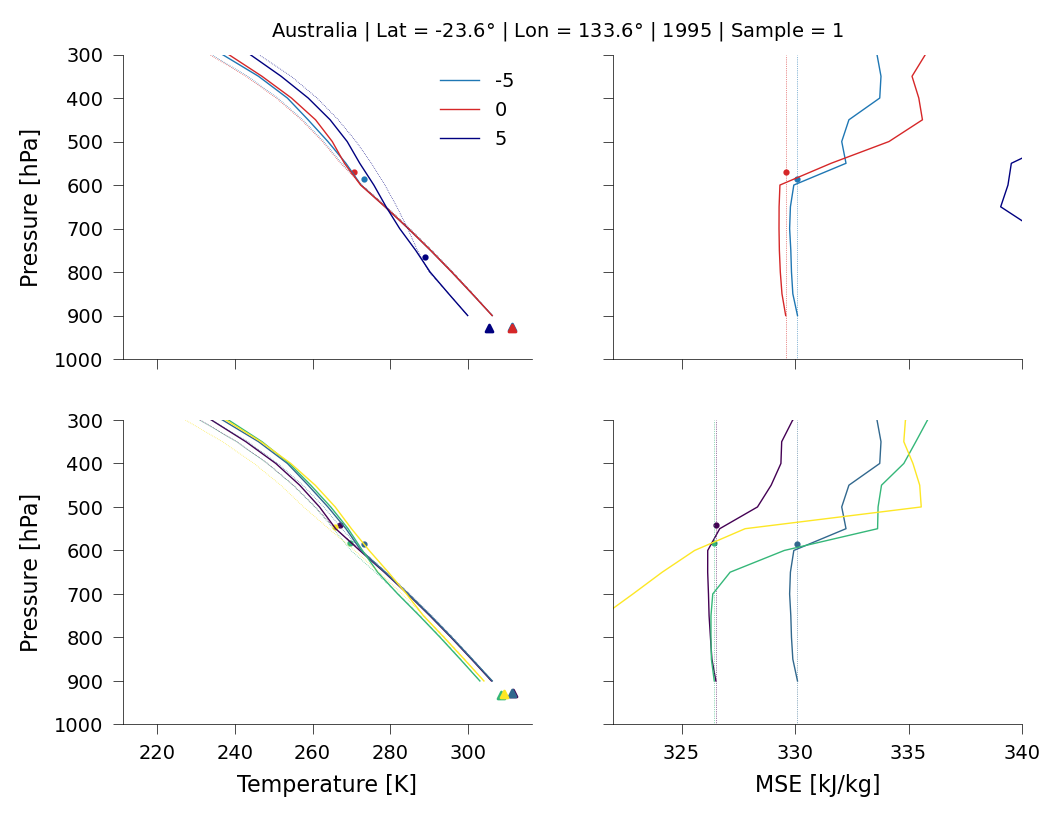

In [412]:
loc_plot = 'australia'
# sample_ind = 90 # spain good one
sample_ind = int(ds_hot.sel(lag=0, loc=loc_plot).t2m.argmax())           # hottest day
sample_ind=1
sqe_use = 5
sqe_use = ''
ds_use = ds_hot.isel(sample=sample_ind).sel(loc=loc_plot).sel(lag=[5, 0, -5])

for var in ds_use:
    if 'plev' in ds_use[var].dims:
        ds_use[var] = ds_use[var].where(ds_use.plev < ds_use.sp/100)
fig, ax = plt.subplots(2, 2, sharey=True, sharex='col')
isca_tools.plot.fig_resize(fig, 5.8)
color_use = ['C0', 'C3', 'navy']
for i in range(ds_use.lag.size):
    ax[0, 0].plot(ds_use.t.isel(lag=i), ds_use.plev, color=color_use[i], label=f'{-ds_use.lag[i]:.0f}')
    ax[0, 0].plot(ds_use[f't_sqe{sqe_use}'].isel(lag=i), ds_use.plev, color=color_use[i], linestyle=':', lw=ax_linewidth)
    ax[0, 0].scatter(ds_use[f't_lcl{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[0, 1].plot(ds_use[f'mse_env{sqe_use}'].isel(lag=i), ds_use.plev, color=color_use[i])
    ax[0, 1].axvline(ds_use[f'mse_low_lev{sqe_use}'].isel(lag=i), color=color_use[i], lw=ax_linewidth, linestyle=':')
    ax[0, 1].scatter(ds_use[f'mse_low_lev{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[0, 0].scatter(ds_use.t2m.isel(lag=i), ds_use.sp.isel(lag=i)/100, color=color_use[i], marker='^')

ds_use = ds_hot.isel(sample=sample_ind).sel(loc=loc_plot).sel(lag=np.arange(8)[::-2])
for var in ds_use:
    if 'plev' in ds_use[var].dims:
        ds_use[var] = ds_use[var].where(ds_use.plev < ds_use.sp/100)

color_use = plt.cm.viridis(np.linspace(0, 1, ds_use.lag.size))
for i in range(ds_use.lag.size):
    ax[1, 0].plot(ds_use.t.isel(lag=i), ds_use.plev, color=color_use[i], label=f'{-ds_use.lag[i]:.0f}')
    ax[1, 0].plot(ds_use[f't_sqe{sqe_use}'].isel(lag=i), ds_use.plev, color=color_use[i], linestyle=':', lw=ax_linewidth)
    ax[1, 0].scatter(ds_use[f't_lcl{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[1, 1].plot(ds_use[f'mse_env{sqe_use}'].isel(lag=i), ds_use.plev, color=color_use[i])
    ax[1, 1].axvline(ds_use[f'mse_low_lev{sqe_use}'].isel(lag=i), color=color_use[i], lw=ax_linewidth, linestyle=':')
    ax[1, 1].scatter(ds_use[f'mse_low_lev{sqe_use}'].isel(lag=i), ds_use[f'p_lcl{sqe_use}'].isel(lag=i)/100, color=color_use[i], marker='.')
    ax[1, 0].scatter(ds_use.t2m.isel(lag=i), ds_use.sp.isel(lag=i)/100, color=color_use[i], marker='^')

# for ax_use in ax.flatten():
#     ax_use.axhline(ds_use.p.isel(lev=refht_level_index).mean()/100, color='k', lw=ax_linewidth)

fig.suptitle(
    f'{loc_plot.capitalize()} | Lat = {ds_use.latitude:.1f}$\degree$ | Lon = {ds_use.longitude:.1f}$\degree$ |'
    f' {year} | Sample = {sample_ind}', y=0.92, fontsize=7)
ax[1, 0].set_xlabel('Temperature [K]')
ax[1, 1].set_xlabel('MSE [kJ/kg]')
ax[0, 0].set_ylabel('Pressure [hPa]')
ax[1, 0].set_ylabel('Pressure [hPa]')
# ax[1].set_xlabel('Temperature change [K]')
ax[0, 0].legend()
# ax[1, 0].legend()
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylim(1000, 300)
ax[0, 1].set_xlim(322, 340)
# isca_tools.plot.update_linewidth(fig)
# ax[0].legend()
# ax[1].axvline(0, color='k', lw=ax_linewidth)
plt.show()
# isca_tools.savefig(fig)

### Evolution of effective vs physical humidity


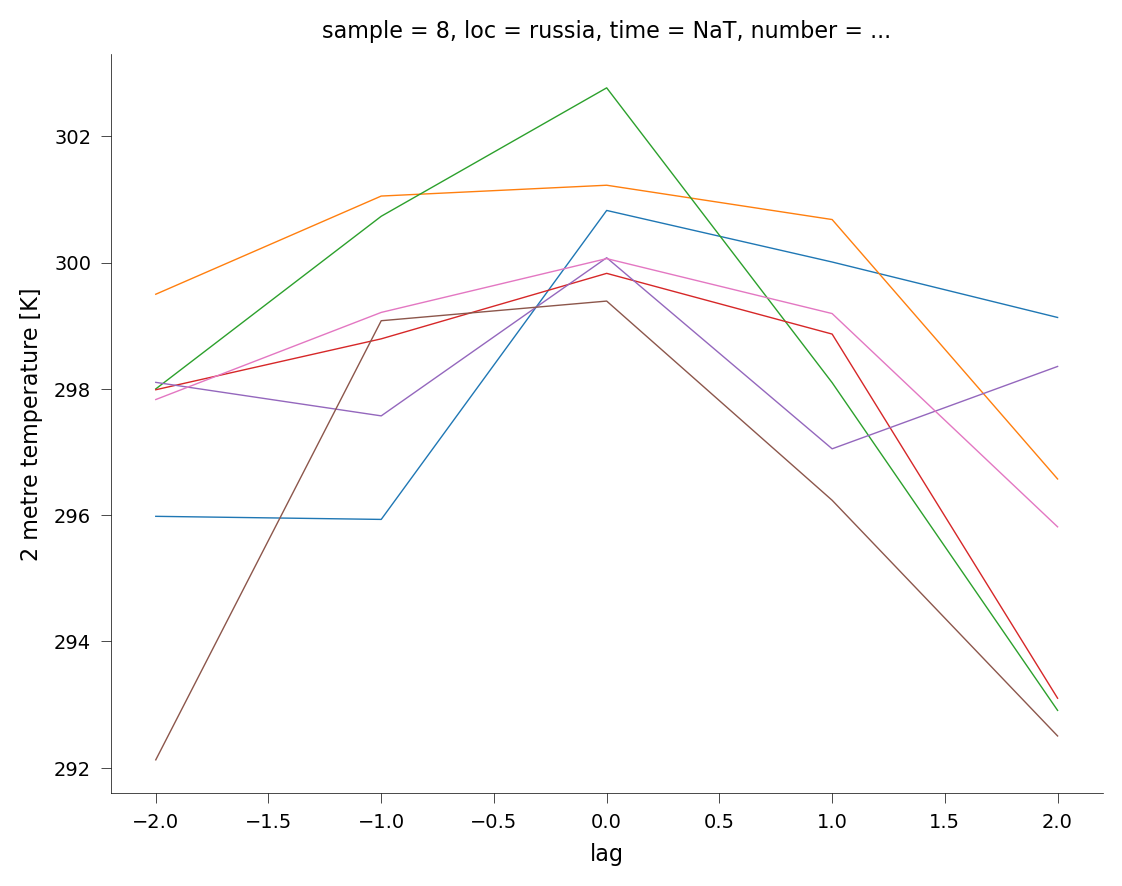

In [349]:
for i in range(ds_hot.sample.size):
    ds_hot.t2m.isel(loc=0, sample=i).sel(lag=slice(2, -2)).plot()

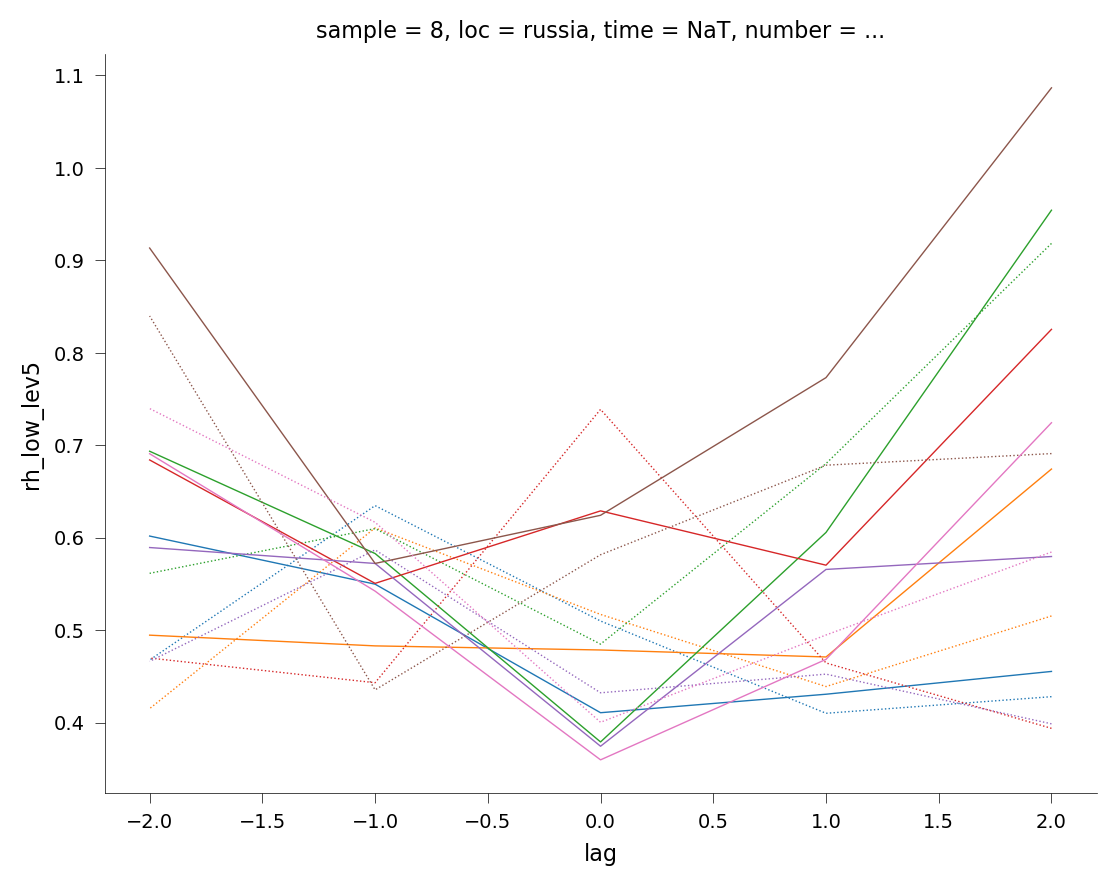

In [366]:
for i in range(ds_hot.sample.size):
    ds_hot.rh_low_lev.isel(loc=0, sample=i).sel(lag=slice(2, -2)).plot(color=f'C{i}', linestyle=':')
    ds_hot.rh_low_lev5.isel(loc=0, sample=i).sel(lag=slice(2, -2)).plot(color=f'C{i}')

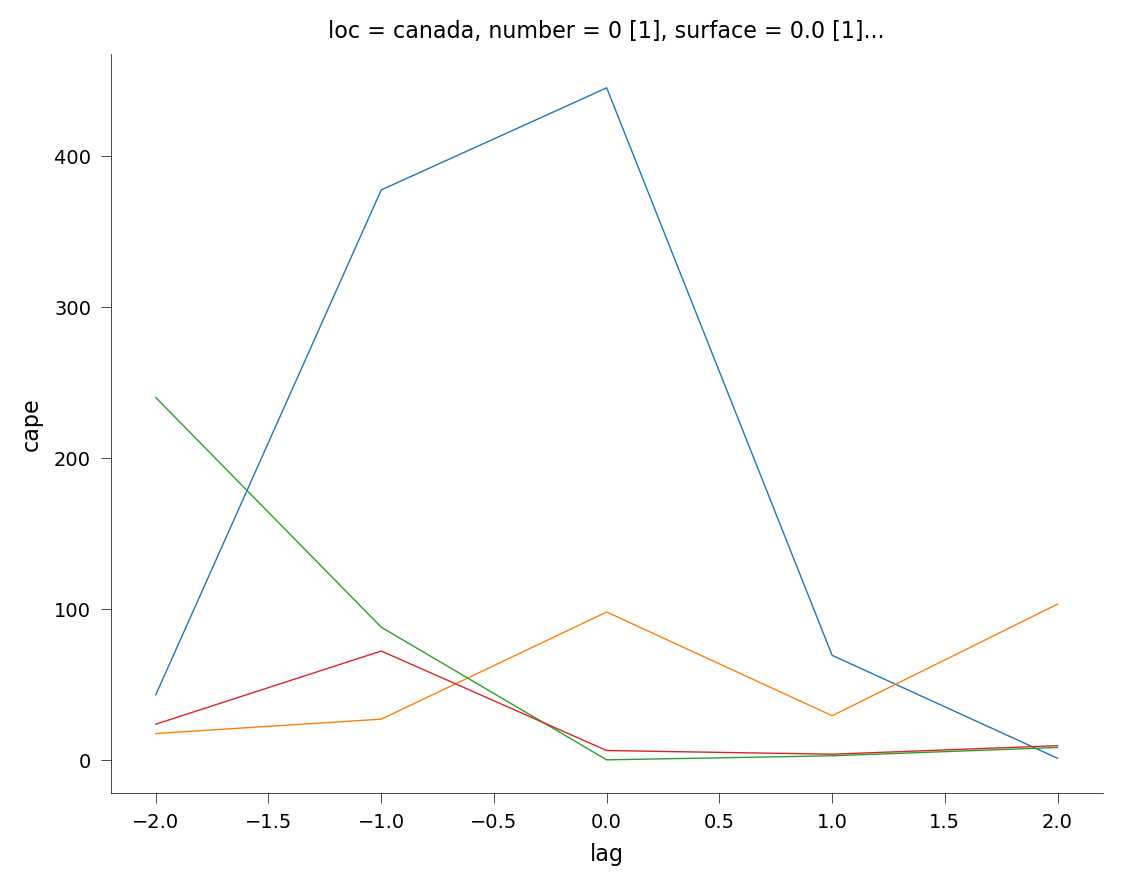

In [377]:
for i in range(n_loc):
    ds_hot.cape.isel(loc=i).sel(lag=slice(2, -2)).mean(dim='sample').plot(color=f'C{i}')

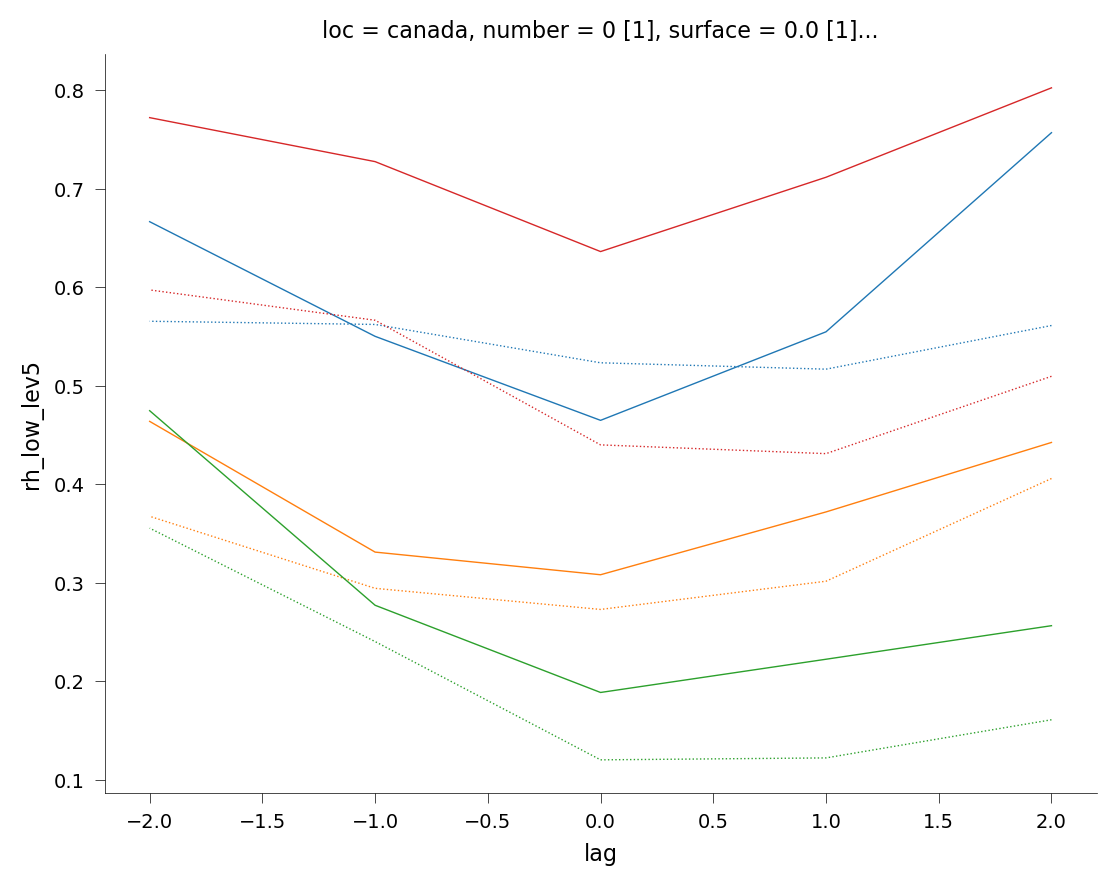

In [375]:
for i in range(n_loc):
    ds_hot.rh_low_lev.isel(loc=i).sel(lag=slice(2, -2)).mean(dim='sample').plot(color=f'C{i}', linestyle=':')
    ds_hot.rh_low_lev5.isel(loc=i).sel(lag=slice(2, -2)).mean(dim='sample').plot(color=f'C{i}')

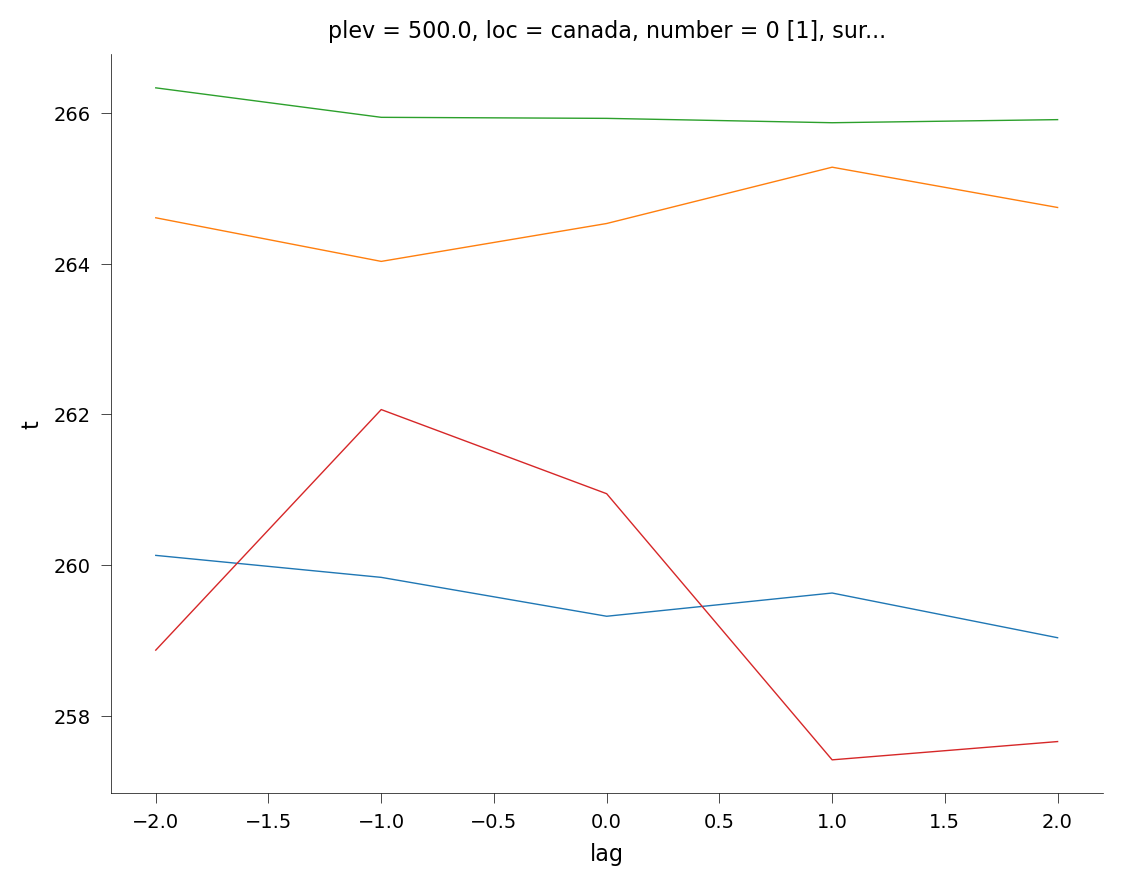

In [372]:
for i in range(n_loc):
    ds_hot.t.isel(loc=i).sel(plev=500).sel(lag=slice(2, -2)).mean(dim='sample').plot()

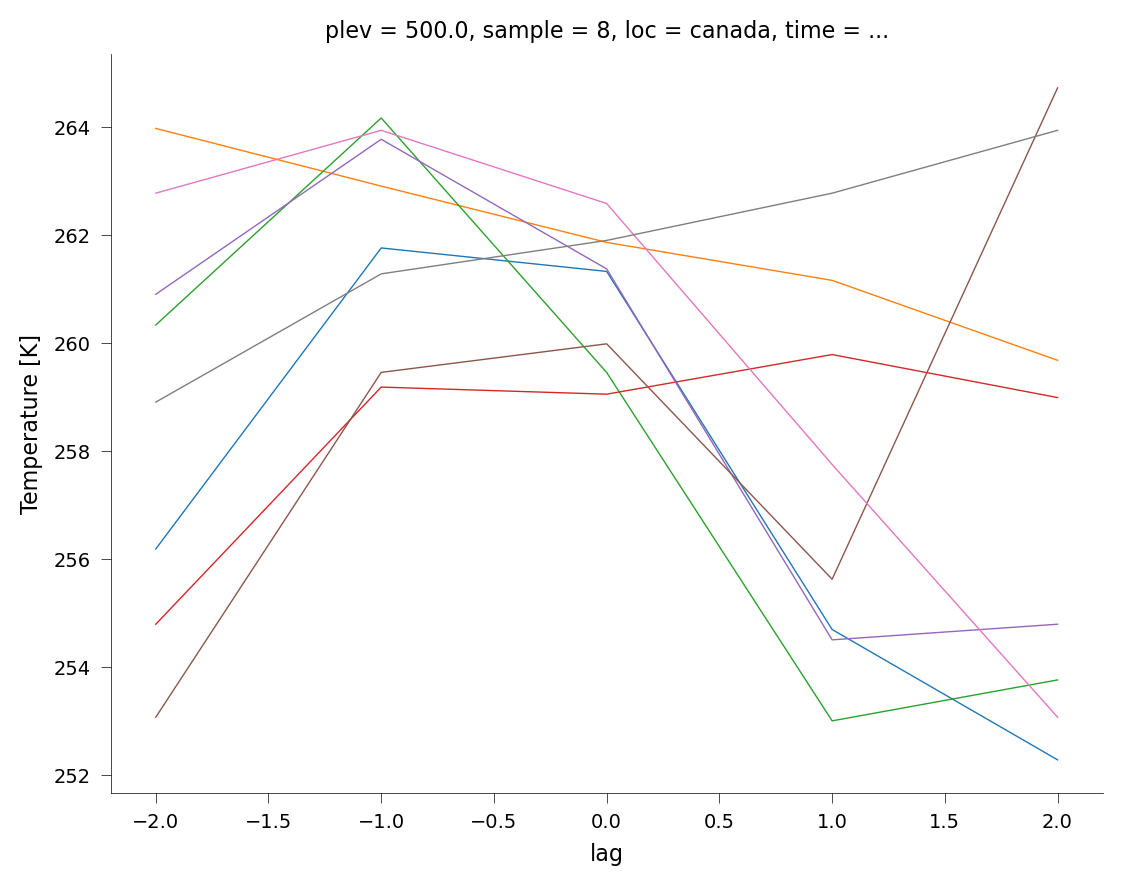

In [369]:
for i in range(ds_hot.sample.size):
    ds_hot.t.isel(loc=3, sample=i).sel(plev=500).sel(lag=slice(2, -2)).plot()

In [303]:
# TODO: plot time series of CAPE, humidity

In [301]:
ds_hot.q_low_lev

<xarray.DataArray 'q_low_lev' (loc: 4, lag: 15, sample: 9)> Size: 2kB
array([[[0.00498103, 0.00718793, 0.00686715, 0.00401273, 0.00584168,
         0.01036467, 0.0051081 ,        nan,        nan],
        [0.00338299, 0.00729033, 0.00775413, 0.00664792, 0.00675634,
         0.00903919, 0.0054311 ,        nan,        nan],
        [0.00391089, 0.00904519, 0.00960927, 0.00443689, 0.00493407,
         0.00842793, 0.00683191,        nan,        nan],
        [0.00386943, 0.00962206, 0.01146602, 0.0055334 , 0.00524559,
         0.00779836, 0.0066775 ,        nan,        nan],
        [0.0066884 , 0.00726692, 0.00693371, 0.00863046, 0.005509  ,
         0.00639975, 0.00809192,        nan,        nan],
        [0.00718793, 0.00686715, 0.01128205, 0.00492813, 0.00615222,
         0.00777764, 0.00796384,        nan,        nan],
        [0.00729033, 0.00775413, 0.01151606, 0.00792636, 0.00684479,
         0.00973656, 0.00869883,        nan,        nan],
        [0.00904519, 0.00960927, 0.01098841, 0.01207142, 0.00754347,
         0.00908361, 0.00799862,        nan,        nan],
        [0.00962206, 0.01146602, 0.01088251, 0.00733988, 0.00872959,
         0.00745137, 0.01053425,        nan,        nan],
        [0.00726692, 0.00693371, 0.00860355, 0.00688999, 0.00815735,
         0.01051711, 0.01258098,        nan,        nan],
...
        [0.00328996, 0.00481105, 0.00450879, 0.0057066 , 0.00572547,
         0.00961009, 0.00726758, 0.00808302,        nan],
        [0.00349844, 0.00380789, 0.00592272, 0.00596654, 0.0047212 ,
         0.00686681, 0.00626404, 0.00666279,        nan],
        [0.00352398, 0.00602914, 0.0082809 , 0.00672018, 0.00591026,
         0.00763462, 0.00675437, 0.0096111 ,        nan],
        [0.00642999, 0.00646686, 0.01180179, 0.00751562, 0.00709561,
         0.00838571, 0.00808302, 0.0108094 ,        nan],
        [0.00479756, 0.00659363, 0.00989144, 0.00572547, 0.00805727,
         0.00726758, 0.00666279, 0.00994305,        nan],
        [0.00622485, 0.00460377, 0.00965135, 0.0047212 , 0.01074115,
         0.00626404, 0.0096111 , 0.00516051,        nan],
        [0.00388092, 0.00641597, 0.00562786, 0.00591026, 0.00961009,
         0.00675437, 0.0108094 , 0.00590407,        nan],
        [0.00481105, 0.00450879, 0.0070135 , 0.00709561, 0.00686681,
         0.00808302, 0.00994305, 0.00696794,        nan],
        [0.00380789, 0.00592272, 0.00435922, 0.00805727, 0.00763462,
         0.00666279, 0.00516051, 0.01037915,        nan],
        [0.00602914, 0.0082809 , 0.00580822, 0.01074115, 0.00838571,
         0.0096111 , 0.00590407, 0.00417847,        nan]]], dtype=float32)
Coordinates:
  * lag                  (lag) int64 120B 7 6 5 4 3 2 1 0 -1 -2 -3 -4 -5 -6 -7
  * sample               (sample) int64 72B 0 1 2 3 4 5 6 7 8
  * loc                  (loc) <U9 144B 'russia' 'spain' 'australia' 'canada'
    time                 (loc, sample) datetime64[ns] 288B 1995-06-12T09:00:0...
    number               int64 8B 0
    surface              float64 8B 0.0
    latitude             (loc) float32 16B 60.4 40.35 -23.65 55.35
    longitude            (loc) float32 16B 49.6 -5.4 133.6 -70.4
    depthBelowLandLayer  float64 8B 0.0
    quantile             float64 8B 0.8
Attributes: (12/31)
    GRIB_paramId:                             133
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      16
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           q
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Specific humidity
    units:                                    kg kg**-1
    standard_name:                            specific_humidity